In [1]:
pip install pycryptodome


Note: you may need to restart the kernel to use updated packages.


In [4]:
from Crypto.PublicKey import RSA
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad
from base64 import b64encode, b64decode
import time

def generate_rsa_key():
    key = RSA.generate(2048)
    return key

def encrypt_message(public_key, message):
    # Generate a random 256-bit AES key
    aes_key = get_random_bytes(32)

    # Encrypt the message with AES-256 using the random key
    cipher_aes = AES.new(aes_key, AES.MODE_CBC)
    ct_bytes = cipher_aes.encrypt(pad(message.encode(), AES.block_size))

    # Encrypt the AES key with the recipient's public RSA key using RSA-OAEP
    cipher_rsa = PKCS1_OAEP.new(public_key)
    enc_aes_key = cipher_rsa.encrypt(aes_key)

    # Encode the ciphertext and encrypted AES key as base64
    ct = b64encode(ct_bytes).decode('utf-8')
    encrypted_key = b64encode(enc_aes_key).decode('utf-8')

    # Add timestamp to the message
    timestamp = str(time.time())
    message_with_timestamp = timestamp + ':' + ct

    # Return the encrypted message and encrypted AES key
    return message_with_timestamp, encrypted_key

def decrypt_message(private_key, message_with_timestamp, encrypted_key):
    # Decode the base64-encoded ciphertext and encrypted AES key
    timestamp, ct = message_with_timestamp.split(':', 1)
    ct_bytes = b64decode(ct)
    enc_aes_key = b64decode(encrypted_key)

    # Decrypt the AES key with the recipient's private RSA key using RSA-OAEP
    cipher_rsa = PKCS1_OAEP.new(private_key)
    aes_key = cipher_rsa.decrypt(enc_aes_key)

    # Decrypt the ciphertext with AES-256 using the decrypted AES key
    cipher_aes = AES.new(aes_key, AES.MODE_CBC)
    message_bytes = unpad(cipher_aes.decrypt(ct_bytes), AES.block_size)
    #decrypt(unpad(ciphertext, BLOCK_SIZE))

    # Check the timestamp to prevent replay attacks
    current_time = time.time()
    message_time = float(timestamp)
    time_diff = abs(current_time - message_time)
    if time_diff > 60:  # assume that messages can't be delayed by more than 60 seconds
        raise ValueError('Message timestamp is invalid')

    # Return the decrypted message
    return message_bytes.decode('utf-8')

# Generate an RSA key pair
recipient_key = generate_rsa_key()

# Text to encrypt
plaintext = "myname"

# Encrypt the text using the recipient's public key
encrypted_message, encrypted_key = encrypt_message(recipient_key.publickey(), plaintext)

# Decrypt the encrypted message using the recipient's private key
try:
    decrypted_message = decrypt_message(recipient_key, encrypted_message, encrypted_key)
    print("Decrypted Message:", decrypted_message)
except Exception as e:
    print("Error:", e)


Error: Padding is incorrect.


# MAIN PROPOSED HYBRID CODE

In [1]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad, unpad
import os
import time

# Function to generate a secure random AES key
def generate_aes_key():
    return os.urandom(32)  # 256 bits for AES-256

# Function to generate a timestamp (in seconds since epoch)
def generate_timestamp():
    return int(time.time())

# Function to encrypt a file using AES with PKCS7 padding
def encrypt_file(file_path, encryption_key):
    cipher = AES.new(encryption_key, AES.MODE_GCM)

    with open(file_path, 'rb') as file:
        file_data = file.read()

    # Pad the plaintext to be a multiple of the block size
    padded_data = pad(file_data, AES.block_size)

    ciphertext, tag = cipher.encrypt_and_digest(padded_data)
    nonce = cipher.nonce

    return nonce + ciphertext + tag

# Function to decrypt a file using AES with PKCS7 padding
def decrypt_file(encrypted_data, encryption_key):
    nonce, ciphertext, tag = (
        encrypted_data[:16],
        encrypted_data[16:-16],
        encrypted_data[-16:]
    )

    cipher = AES.new(encryption_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)

    # Remove PKCS7 padding
    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    return decrypted_data

# Function to generate RSA key pair
def generate_rsa_key_pair():
    rsa_key = RSA.generate(2048)
    rsa_public_key = rsa_key.publickey()
    rsa_private_key = rsa_key
    return rsa_public_key, rsa_private_key

# Function to encrypt AES key using RSA public key
def encrypt_aes_key(aes_key, rsa_public_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_public_key)
    enc_aes_key = cipher_rsa.encrypt(aes_key)
    return enc_aes_key

# Function to decrypt AES key using RSA private key
def decrypt_aes_key(enc_aes_key, rsa_private_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_private_key)
    aes_key = cipher_rsa.decrypt(enc_aes_key)
    return aes_key

# Function to encrypt a file with a timestamp
def encrypt_file_with_timestamp(file_path, rsa_public_key):
    timestamp = generate_timestamp()
    aes_key = generate_aes_key()
    encrypted_data = encrypt_file(file_path, aes_key)
    
    # Encrypt the AES key using RSA public key
    enc_aes_key = encrypt_aes_key(aes_key, rsa_public_key)
    
    return enc_aes_key + encrypted_data

# Function to decrypt a file with timestamp validation
def decrypt_file_with_timestamp(encrypted_data_with_timestamp, rsa_private_key):
    # Split the data into encrypted AES key and encrypted data
    enc_aes_key, encrypted_data = (
        encrypted_data_with_timestamp[:256],
        encrypted_data_with_timestamp[256:]
    )
    
    # Decrypt the AES key using RSA private key
    aes_key = decrypt_aes_key(enc_aes_key, rsa_private_key)
    
    decrypted_data = decrypt_file(encrypted_data, aes_key)
    
    return decrypted_data

# Example usage
def main():
    # Generate RSA key pair for secure key exchange
    rsa_public_key, rsa_private_key = generate_rsa_key_pair()

    # Specify the file path to the file you want to encrypt
    file_to_encrypt = r"C:\Users\eLife\Desktop\sample.txt" # Insert your file path here

    # Encrypt the file with a timestamp using RSA public key
    encrypted_data_with_timestamp = encrypt_file_with_timestamp(file_to_encrypt, rsa_public_key)

    # Decrypt the file with timestamp validation using RSA private key
    decrypted_data = decrypt_file_with_timestamp(encrypted_data_with_timestamp, rsa_private_key)
    
    # Display the decrypted binary data
    print("Decrypted Data (Binary):", decrypted_data)

if __name__ == "__main__":
    main()


Decrypted Data (Binary): b'Video provides a powerful way to help you prove your point. When you click Online Video, you can paste in the embed code for the video you want to add. You can also type a keyword to search online for the video that best fits your document. To make your document look professionally produced, Word provides header, footer, cover page, and text box designs that complement each other. For example, you can add a matching cover page, header, and sidebar.\r\nClick Insert and then choose the elements you want from the different galleries. Themes and styles also help keep your document coordinated. When you click Design and choose a new Theme, the pictures, charts, and SmartArt graphics change to match your new theme. When you apply styles, your headings change to match the new theme. Save time in Word with new buttons that show up where you need them.\r\nTo change the way a picture fits in your document, click it and a button for layout options appears next to it. Wh

start_time = time.time()
for _ in range(100):
    encrypt_file(original_data, encryption_key)
end_time = time.time()
encryption_time = end_time - start_time
print(f"Encryption Time for 100 iterations: {encryption_time} seconds")

In [51]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad, unpad
import os
import time

# Functions from your previous code
def generate_aes_key():
    return os.urandom(32)  # 256 bits for AES-256

def generate_timestamp():
    return int(time.time())

def encrypt_file(file_path, encryption_key):
    cipher = AES.new(encryption_key, AES.MODE_GCM)

    with open(file_path, 'rb') as file:
        file_data = file.read()

    padded_data = pad(file_data, AES.block_size)

    ciphertext, tag = cipher.encrypt_and_digest(padded_data)
    nonce = cipher.nonce

    return nonce + ciphertext + tag

def decrypt_file(encrypted_data, encryption_key):
    nonce, ciphertext, tag = (
        encrypted_data[:16],
        encrypted_data[16:-16],
        encrypted_data[-16:]
    )

    cipher = AES.new(encryption_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)

    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    return decrypted_data

def generate_rsa_key_pair():
    rsa_key = RSA.generate(2048)
    rsa_public_key = rsa_key.publickey()
    rsa_private_key = rsa_key
    return rsa_public_key, rsa_private_key

def encrypt_aes_key(aes_key, rsa_public_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_public_key)
    enc_aes_key = cipher_rsa.encrypt(aes_key)
    return enc_aes_key

def decrypt_aes_key(enc_aes_key, rsa_private_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_private_key)
    aes_key = cipher_rsa.decrypt(enc_aes_key)
    return aes_key

def encrypt_file_with_timestamp(file_path, rsa_public_key):
    timestamp = generate_timestamp()
    aes_key = generate_aes_key()
    encrypted_data = encrypt_file(file_path, aes_key)
    enc_aes_key = encrypt_aes_key(aes_key, rsa_public_key)
    return enc_aes_key + encrypted_data

def decrypt_file_with_timestamp(encrypted_data_with_timestamp, rsa_private_key):
    enc_aes_key, encrypted_data = (
        encrypted_data_with_timestamp[:256],
        encrypted_data_with_timestamp[256:]
    )
    aes_key = decrypt_aes_key(enc_aes_key, rsa_private_key)
    decrypted_data = decrypt_file(encrypted_data, aes_key)
    return decrypted_data

# Function to create a random file of a specified size
def create_random_file(file_path, size_bytes):
    with open(file_path, 'wb') as file:
        file.write(os.urandom(size_bytes))

# Function to measure encryption and decryption speed for a file
def measure_encryption_decryption_speed(file_size_bytes):
    rsa_public_key, rsa_private_key = generate_rsa_key_pair()

    # Generate a random file of the specified size
    file_size_bytes = int(round(file_size_bytes))
    file_path = f"random_{file_size_bytes}_bytes.bin"
    create_random_file(file_path, file_size_bytes)
    file_path =  r"C:\Users\eLife\Desktop\sample.txt" # Insert your file path here

    file_size = os.path.getsize(file_path)
    print(f"File Size in Bytes is {file_size/1024/1024}")

    # Encrypt the file and measure encryption time
    start_time = time.time()
    encrypted_data_with_timestamp = encrypt_file_with_timestamp(file_path, rsa_public_key)
    encryption_time = time.time() - start_time

    # Decrypt the file and measure decryption time
    start_time = time.time()
    decrypted_data = decrypt_file_with_timestamp(encrypted_data_with_timestamp, rsa_private_key)
    decryption_time = time.time() - start_time

    # Clean up the temporary file
    os.remove(file_path)

    return encryption_time, decryption_time

def main():
    file_sizes = [1.9 * 1024 * 1024, 3.57 * 1024 * 1024, 7.14 * 1024 * 1024, 10.7 * 1024 * 1024, 17.8 * 1024 * 1024, 21.4 * 1024 * 1024, 25 * 1024 * 1024, 28.5 * 1024 * 1024, 32.1 * 1024 * 1024, 35.7 * 1024 * 1024, 39.2 * 1024 * 1024, 42.8 * 1024 * 1024, 46.4 * 1024 * 1024, 50 * 1024 * 1024]  # 10MB and 15MB
    for size in file_sizes:
        encryption_time, decryption_time = measure_encryption_decryption_speed(size)
        print(f"File Size: {size / (1024 * 1024)} MB")
        print(f"Encryption Time: {encryption_time:.2f} seconds")
        print(f"Decryption Time: {decryption_time:.2f} seconds")
        print()

if __name__ == "__main__":
    main()


File Size: 1.9 MB
Encryption Time: 0.06 seconds
Decryption Time: 0.02 seconds

File Size: 3.57 MB
Encryption Time: 0.06 seconds
Decryption Time: 0.02 seconds

File Size: 7.14 MB
Encryption Time: 0.05 seconds
Decryption Time: 0.04 seconds

File Size: 10.7 MB
Encryption Time: 0.09 seconds
Decryption Time: 0.08 seconds

File Size: 17.8 MB
Encryption Time: 0.18 seconds
Decryption Time: 0.13 seconds

File Size: 21.4 MB
Encryption Time: 0.20 seconds
Decryption Time: 0.16 seconds

File Size: 25.0 MB
Encryption Time: 0.20 seconds
Decryption Time: 0.18 seconds

File Size: 28.5 MB
Encryption Time: 0.19 seconds
Decryption Time: 0.14 seconds

File Size: 32.1 MB
Encryption Time: 0.21 seconds
Decryption Time: 0.15 seconds

File Size: 35.7 MB
Encryption Time: 0.23 seconds
Decryption Time: 0.17 seconds

File Size: 39.2 MB
Encryption Time: 0.24 seconds
Decryption Time: 0.19 seconds

File Size: 42.8 MB
Encryption Time: 0.32 seconds
Decryption Time: 0.21 seconds

File Size: 46.4 MB
Encryption Time: 0.29 

In [49]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad, unpad
import os
import time

# ... (Your encryption and decryption functions as defined earlier)

# Functions from your previous code
def generate_aes_key():
    return os.urandom(32)  # 256 bits for AES-256

def generate_timestamp():
    return int(time.time())

def encrypt_file(file_path, encryption_key):
    cipher = AES.new(encryption_key, AES.MODE_GCM)

    with open(file_path, 'rb') as file:
        file_data = file.read()

    padded_data = pad(file_data, AES.block_size)

    ciphertext, tag = cipher.encrypt_and_digest(padded_data)
    nonce = cipher.nonce

    return nonce + ciphertext + tag



#def decrypt_file(encrypted_data, encryption_key):
 #   nonce, ciphertext, tag = (
  #      encrypted_data[:16],
   #     encrypted_data[16:-16],
    #    encrypted_data[-16:]
    #)


def decrypt_file(encrypted_data, encryption_key):
    nonce, ciphertext, tag = (
        encrypted_data[:16],
        encrypted_data[16:-16],
        encrypted_data[-16:]
    )
#######################

    cipher = AES.new(encryption_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)

    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    return decrypted_data

def generate_rsa_key_pair():
    rsa_key = RSA.generate(2048)
    rsa_public_key = rsa_key.publickey()
    rsa_private_key = rsa_key
    return rsa_public_key, rsa_private_key

def encrypt_aes_key(aes_key, rsa_public_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_public_key)
    enc_aes_key = cipher_rsa.encrypt(aes_key)
    return enc_aes_key

def decrypt_aes_key(enc_aes_key, rsa_private_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_private_key)
    aes_key = cipher_rsa.decrypt(enc_aes_key)
    return aes_key





def encrypt_file_with_timestamp(file_path, rsa_public_key):
    timestamp = generate_timestamp()
    aes_key = generate_aes_key()
    encrypted_data = encrypt_file(file_path, aes_key)
    enc_aes_key = encrypt_aes_key(aes_key, rsa_public_key)
    return enc_aes_key + encrypted_data

def decrypt_file_with_timestamp(encrypted_data_with_timestamp, rsa_private_key):
    enc_aes_key, encrypted_data = (
        encrypted_data_with_timestamp[:256],
        encrypted_data_with_timestamp[256:]
    )
    aes_key = decrypt_aes_key(enc_aes_key, rsa_private_key)
    decrypted_data = decrypt_file(encrypted_data, aes_key)
    return decrypted_data

# Function to create a random file of a specified size
def create_random_file(file_path, size_bytes):
    with open(file_path, 'wb') as file:
        file.write(os.urandom(size_bytes))






#################################################





# Function to measure RSA encryption and decryption speed for a file
def measure_rsa_encryption_decryption_speed(file_size_bytes):
    rsa_public_key, rsa_private_key = generate_rsa_key_pair()

    # Generate a random file of the specified size (rounded to the nearest integer)
    file_size_bytes = int(round(file_size_bytes))
    file_path = f"random_{file_size_bytes}_bytes.bin"
    create_random_file(file_path, file_size_bytes)

    # RSA Encryption
    start_time = time.time()
    enc_aes_key = encrypt_aes_key(generate_aes_key(), rsa_public_key)
    rsa_encryption_time = time.time() - start_time

    # RSA Decryption
    start_time = time.time()
    aes_key = decrypt_aes_key(enc_aes_key, rsa_private_key)
    rsa_decryption_time = time.time() - start_time

    # Clean up the temporary file
    os.remove(file_path)

    return rsa_encryption_time, rsa_decryption_time

# Function to measure AES encryption and decryption speed for a file
#def measure_aes_encryption_decryption_speed(file_size_bytes):
    # Generate a random file of the specified size (rounded to the nearest integer)
   # file_size_bytes = int(round(file_size_bytes))
    #file_path = f"random_{file_size_bytes}_bytes.bin"
    #create_random_file(file_path, file_size_bytes)

    # AES Encryption
   # aes_key = generate_aes_key()
   # start_time = time.time()
    #encrypted_data_with_timestamp = encrypt_file_with_timestamp(file_path, aes_key)
   # aes_encryption_time = time.time() - start_time

    # AES Decryption
    #start_time = time.time()
    #decrypted_data = decrypt_file_with_timestamp(encrypted_data_with_timestamp, aes_key)
   # aes_decryption_time = time.time() - start_time

    # Clean up the temporary file
    #os.remove(file_path)

    #return aes_encryption_time, aes_decryption_time

#################################################################

# Modify the measure_aes_encryption_decryption_speed function to properly handle the nonce
def measure_aes_encryption_decryption_speed(file_size_bytes):
    # Generate a random file of the specified size (rounded to the nearest integer)
    file_size_bytes = int(round(file_size_bytes))
    file_path = f"random_{file_size_bytes}_bytes.bin"
    create_random_file(file_path, file_size_bytes)

    # AES Encryption
    aes_key = generate_aes_key()
    start_time = time.time()  # Initialize start_time here
    cipher = AES.new(aes_key, AES.MODE_GCM)  # Create a new cipher with a random nonce
    with open(file_path, 'rb') as file:
        file_data = file.read()
    ciphertext, tag = cipher.encrypt_and_digest(pad(file_data, AES.block_size))
    nonce = cipher.nonce
    encrypted_data_with_timestamp = nonce + ciphertext + tag

    aes_encryption_time = time.time() - start_time

    # AES Decryption
    start_time = time.time()  # Initialize start_time again here
    nonce = encrypted_data_with_timestamp[:16]  # Extract the nonce
    ciphertext = encrypted_data_with_timestamp[16:-16]
    tag = encrypted_data_with_timestamp[-16:]
    cipher = AES.new(aes_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)
    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    aes_decryption_time = time.time() - start_time

    # Clean up the temporary file
    os.remove(file_path)

    return aes_encryption_time, aes_decryption_time

def main():
    file_sizes = [1.9 * 1024 * 1024, 3.57 * 1024 * 1024, 7.14 * 1024 * 1024, 10.7 * 1024 * 1024, 17.8 * 1024 * 1024, 21.4 * 1024 * 1024, 25 * 1024 * 1024, 28.5 * 1024 * 1024, 32.1 * 1024 * 1024, 35.7 * 1024 * 1024, 39.2 * 1024 * 1024, 42.8 * 1024 * 1024, 46.4 * 1024 * 1024, 50 * 1024 * 1024]

    for size in file_sizes:
        rsa_encryption_time, rsa_decryption_time = measure_rsa_encryption_decryption_speed(size)
        aes_encryption_time, aes_decryption_time = measure_aes_encryption_decryption_speed(size)

        print(f"File Size: {size / (1024 * 1024)} MB")
        print(f"RSA Encryption Time: {rsa_encryption_time:.2f} seconds")
        print(f"RSA Decryption Time: {rsa_decryption_time:.2f} seconds")
       # print(f"AES Encryption Time: {aes_encryption_time:.2f} seconds")
        #print(f"AES Decryption Time: {aes_decryption_time:.2f} seconds")
        print()

if __name__ == "__main__":
    main()


File Size: 1.9 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 3.57 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 7.14 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 10.7 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 17.8 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 21.4 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 25.0 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 28.5 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.01 seconds

File Size: 32.1 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.02 seconds

File Size: 35.7 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.02 seconds

File Size: 39.2 MB
RSA Encryption Time: 0.00 seconds
RSA Decryption Time: 0.02 seconds

File Size: 42.8 MB
RSA Encryption

In [48]:
def measure_aes_encryption_decryption_speed(file_size_bytes):
    # Generate a random file of the specified size (rounded to the nearest integer)
    file_size_bytes = int(round(file_size_bytes))
    file_path = f"random_{file_size_bytes}_bytes.bin"
    create_random_file(file_path, file_size_bytes)

    # AES Encryption
    aes_key = generate_aes_key()
    start_time = time.time()  # Initialize start_time here
    cipher = AES.new(aes_key, AES.MODE_GCM)  # Create a new cipher with a random nonce
    with open(file_path, 'rb') as file:
        file_data = file.read()
    ciphertext, tag = cipher.encrypt_and_digest(pad(file_data, AES.block_size))
    nonce = cipher.nonce
    encrypted_data_with_timestamp = nonce + ciphertext + tag

    aes_encryption_time = time.time() - start_time

    # AES Decryption
    start_time = time.time()  # Initialize start_time again here
    nonce = encrypted_data_with_timestamp[:16]  # Extract the nonce
    ciphertext = encrypted_data_with_timestamp[16:-16]
    tag = encrypted_data_with_timestamp[-16:]
    cipher = AES.new(aes_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)
    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    aes_decryption_time = time.time() - start_time

    # Clean up the temporary file
    os.remove(file_path)

    return aes_encryption_time, aes_decryption_time



def main():
    file_sizes = [1.19 * 1024 * 1024, 3.57 * 1024 * 1024, 7.14 * 1024 * 1024, 10.7 * 1024 * 1024, 17.8* 1024 * 1024, 21.4 * 1024 * 1024, 25* 1024 * 1024, 28.5* 1024 * 1024, 32.1* 1024 * 1024, 35.7* 1024 * 1024, 39.2* 1024 * 1024, 42.8* 1024 * 1024, 46.4 * 1024 * 1024, 50* 1024 * 1024]

    for size in file_sizes:
        rsa_encryption_time, rsa_decryption_time = measure_rsa_encryption_decryption_speed(size)
        aes_encryption_time, aes_decryption_time = measure_aes_encryption_decryption_speed(size)

        print(f"File Size: {size / (1024 * 1024)} MB")
        #print(f"RSA Encryption Time: {rsa_encryption_time:.2f} seconds")
        #print(f"RSA Decryption Time: {rsa_decryption_time:.2f} seconds")
        print(f"AES Encryption Time: {aes_encryption_time:.2f} seconds")
        print(f"AES Decryption Time: {aes_decryption_time:.2f} seconds")
        print()

if __name__ == "__main__":
    main()

File Size: 1.19 MB
AES Encryption Time: 0.01 seconds
AES Decryption Time: 0.00 seconds

File Size: 3.57 MB
AES Encryption Time: 0.02 seconds
AES Decryption Time: 0.01 seconds

File Size: 7.14 MB
AES Encryption Time: 0.04 seconds
AES Decryption Time: 0.03 seconds

File Size: 10.7 MB
AES Encryption Time: 0.07 seconds
AES Decryption Time: 0.06 seconds

File Size: 17.8 MB
AES Encryption Time: 0.09 seconds
AES Decryption Time: 0.07 seconds

File Size: 21.4 MB
AES Encryption Time: 0.12 seconds
AES Decryption Time: 0.07 seconds

File Size: 25.0 MB
AES Encryption Time: 0.15 seconds
AES Decryption Time: 0.09 seconds

File Size: 28.5 MB
AES Encryption Time: 0.17 seconds
AES Decryption Time: 0.10 seconds

File Size: 32.1 MB
AES Encryption Time: 0.24 seconds
AES Decryption Time: 0.14 seconds

File Size: 35.7 MB
AES Encryption Time: 0.19 seconds
AES Decryption Time: 0.14 seconds

File Size: 39.2 MB
AES Encryption Time: 0.22 seconds
AES Decryption Time: 0.15 seconds

File Size: 42.8 MB
AES Encryptio

# ENCRYPTION AND DECRYPTION SPEED FOR LIN ZOU et al (2020), CHALOOP AND ABDULLAH, PROPOSED APPROACH 

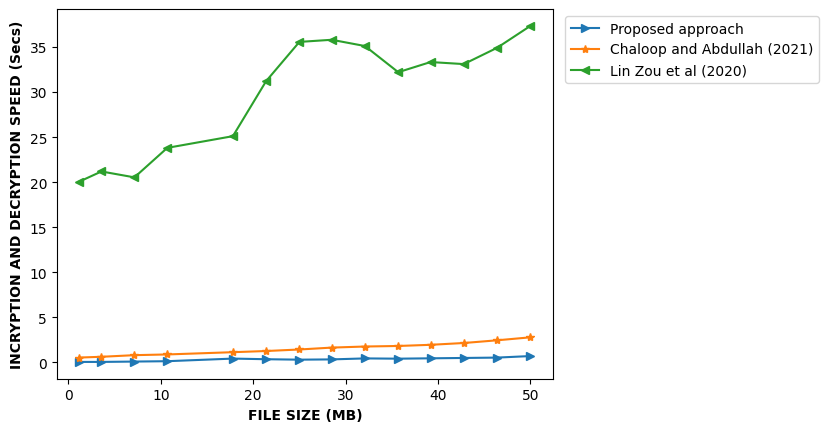

In [42]:
#import numpy as np
import matplotlib.pyplot as plt

x = [1.19, 3.57, 7.14, 10.7, 17.8, 21.4, 25, 28.5, 32.1, 35.7, 39.2, 42.8, 46.4, 50]
y = [0.05, 0.05, 0.09, 0.13, 0.42, 0.35, 0.30, 0.33, 0.44, 0.41, 0.45, 0.49, 0.53, 0.70]

plt.plot(x, y, marker =">", label = "Proposed approach")

x = [1.19, 3.57, 7.14, 10.7, 17.8, 21.4, 25, 28.5, 32.1, 35.7, 39.2, 42.8, 46.4, 50]
y = [0.535, 0.62, 0.8, 0.88, 1.13, 1.26, 1.43, 1.64, 1.76, 1.82, 1.95, 2.15, 2.45, 2.78]

plt.plot(x, y,  marker ="*", label = "Chaloop and Abdullah (2021)")

x = [1.19, 3.57, 7.14, 10.7, 17.8, 21.4, 25, 28.5, 32.1, 35.7, 39.2, 42.8, 46.4, 50]
y = [20.072, 21.191, 20.536, 23.812, 25.11, 31.223, 35.573, 35.809, 35.114, 32.21, 33.337, 33.11, 34.917, 37.347]
plt.plot(x, y,  marker ="<", label = "Lin Zou et al (2020)")

plt.xlabel("FILE SIZE (MB)", fontweight='bold')
plt.ylabel("ENCRYPTION AND DECRYPTION SPEED (Secs)", fontweight='bold')
plt.legend(bbox_to_anchor=(1.55, 1.0), loc='upper right')

plt.show()

# THROUGHPUT RESULT

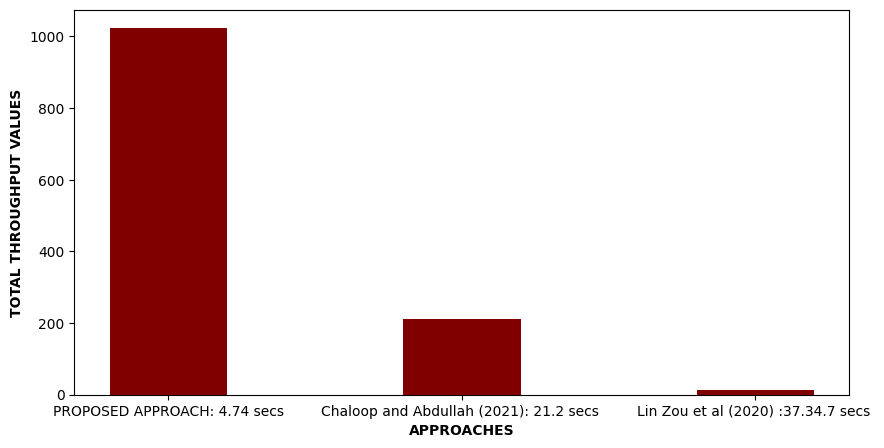

In [43]:
#import numpy as np
import matplotlib.pyplot as plt

data = {'PROPOSED APPROACH: 4.74 secs':1023.5, 'Chaloop and Abdullah (2021): 21.2 secs ':211.4, 'Lin Zou et al (2020) :37.34.7 secs ':12.8}
approaches = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(approaches, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("APPROACHES", fontweight='bold')
plt.ylabel("TOTAL THROUGHPUT VALUES", fontweight='bold')
plt.show()

In [70]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad, unpad
import os
import time

# ... (Your encryption and decryption functions as defined earlier)

# Functions from your previous code
def generate_aes_key():
    return os.urandom(32)  # 256 bits for AES-256

def generate_timestamp():
    return int(time.time())

def encrypt_file(file_path, encryption_key):
    cipher = AES.new(encryption_key, AES.MODE_GCM)

    with open(file_path, 'rb') as file:
        file_data = file.read()

    padded_data = pad(file_data, AES.block_size)

    ciphertext, tag = cipher.encrypt_and_digest(padded_data)
    nonce = cipher.nonce

    return nonce + ciphertext + tag



#def decrypt_file(encrypted_data, encryption_key):
 #   nonce, ciphertext, tag = (
  #      encrypted_data[:16],
   #     encrypted_data[16:-16],
    #    encrypted_data[-16:]
    #)


def decrypt_file(encrypted_data, encryption_key):
    nonce, ciphertext, tag = (
        encrypted_data[:16],
        encrypted_data[16:-16],
        encrypted_data[-16:]
    )
#######################

    cipher = AES.new(encryption_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)

    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    return decrypted_data

def generate_rsa_key_pair():
    rsa_key = RSA.generate(2048)
    rsa_public_key = rsa_key.publickey()
    rsa_private_key = rsa_key
    return rsa_public_key, rsa_private_key

def encrypt_aes_key(aes_key, rsa_public_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_public_key)
    enc_aes_key = cipher_rsa.encrypt(aes_key)
    return enc_aes_key

def decrypt_aes_key(enc_aes_key, rsa_private_key):
    cipher_rsa = PKCS1_OAEP.new(rsa_private_key)
    aes_key = cipher_rsa.decrypt(enc_aes_key)
    return aes_key





def encrypt_file_with_timestamp(file_path, rsa_public_key):
    timestamp = generate_timestamp()
    aes_key = generate_aes_key()
    encrypted_data = encrypt_file(file_path, aes_key)
    enc_aes_key = encrypt_aes_key(aes_key, rsa_public_key)
    return enc_aes_key + encrypted_data

def decrypt_file_with_timestamp(encrypted_data_with_timestamp, rsa_private_key):
    enc_aes_key, encrypted_data = (
        encrypted_data_with_timestamp[:256],
        encrypted_data_with_timestamp[256:]
    )
    aes_key = decrypt_aes_key(enc_aes_key, rsa_private_key)
    decrypted_data = decrypt_file(encrypted_data, aes_key)
    return decrypted_data

# Function to create a random file of a specified size
def create_random_file(file_path, size_bytes):
    with open(file_path, 'wb') as file:
        file.write(os.urandom(size_bytes))






#################################################




file_path =  r"C:\Users\eLife\Desktop\sample.txt" # Insert your file path here

#try:
file_size = os.path.getsize(file_path)
#print(f"File Size in Bytes is {file_size/1024/1024}")
#except FileNotFoundError:

# Function to measure RSA encryption and decryption speed for a file
def measure_rsa_encryption_decryption_speed(file_size):
    rsa_public_key, rsa_private_key = generate_rsa_key_pair()

    # Generate a random file of the specified size (rounded to the nearest integer)
    file_size_bytes = int(round(file_size_bytes))
    file_path = f"random_{file_size_bytes}_bytes.bin"
    create_random_file(file_path, file_size_bytes)

    # RSA Encryption
    start_time = time.time()
    enc_aes_key = encrypt_aes_key(generate_aes_key(), rsa_public_key)
    rsa_encryption_time = time.time() - start_time

    # RSA Decryption
    start_time = time.time()
    aes_key = decrypt_aes_key(enc_aes_key, rsa_private_key)
    rsa_decryption_time = time.time() - start_time

    # Clean up the temporary file
    os.remove(file_path)

    return rsa_encryption_time, rsa_decryption_time

# Function to measure AES encryption and decryption speed for a file
#def measure_aes_encryption_decryption_speed(file_size_bytes):
    # Generate a random file of the specified size (rounded to the nearest integer)
   # file_size_bytes = int(round(file_size_bytes))
    #file_path = f"random_{file_size_bytes}_bytes.bin"
    #create_random_file(file_path, file_size_bytes)

    # AES Encryption
   # aes_key = generate_aes_key()
   # start_time = time.time()
    #encrypted_data_with_timestamp = encrypt_file_with_timestamp(file_path, aes_key)
   # aes_encryption_time = time.time() - start_time

    # AES Decryption
    #start_time = time.time()
    #decrypted_data = decrypt_file_with_timestamp(encrypted_data_with_timestamp, aes_key)
   # aes_decryption_time = time.time() - start_time

    # Clean up the temporary file
    #os.remove(file_path)

    #return aes_encryption_time, aes_decryption_time

#################################################################

# Modify the measure_aes_encryption_decryption_speed function to properly handle the nonce
def measure_aes_encryption_decryption_speed(file_size):
    # Generate a random file of the specified size (rounded to the nearest integer)
    file_size = int(round(file_size))
    file_path = f"random_{file_size}_bytes.bin"
    create_random_file(file_path, file_size)

    # AES Encryption
    aes_key = generate_aes_key()
    start_time = time.time()  # Initialize start_time here
    cipher = AES.new(aes_key, AES.MODE_GCM)  # Create a new cipher with a random nonce
    with open(file_path, 'rb') as file:
        file_data = file.read()
    ciphertext, tag = cipher.encrypt_and_digest(pad(file_data, AES.block_size))
    nonce = cipher.nonce
    encrypted_data_with_timestamp = nonce + ciphertext + tag

    aes_encryption_time = time.time() - start_time

    # AES Decryption
    start_time = time.time()  # Initialize start_time again here
    nonce = encrypted_data_with_timestamp[:16]  # Extract the nonce
    ciphertext = encrypted_data_with_timestamp[16:-16]
    tag = encrypted_data_with_timestamp[-16:]
    cipher = AES.new(aes_key, AES.MODE_GCM, nonce=nonce)
    decrypted_data_with_padding = cipher.decrypt_and_verify(ciphertext, tag)
    decrypted_data = unpad(decrypted_data_with_padding, AES.block_size)

    aes_decryption_time = time.time() - start_time

    # Clean up the temporary file
    os.remove(file_path)

    return aes_encryption_time, aes_decryption_time

def main():
    #file_sizes = [file_size]

    #for size in file_sizes:
    rsa_encryption_time, rsa_decryption_time = measure_rsa_encryption_decryption_speed(file_size)
    aes_encryption_time, aes_decryption_time = measure_aes_encryption_decryption_speed(file_size)

    print(f"File Size: {file_size / 1024 / 1024} MB")
    print(f"RSA Encryption Time: {rsa_encryption_time:.2f} seconds")
    print(f"RSA Decryption Time: {rsa_decryption_time:.2f} seconds")
       # print(f"AES Encryption Time: {aes_encryption_time:.2f} seconds")
        #print(f"AES Decryption Time: {aes_decryption_time:.2f} seconds")
    print()

if __name__ == "__main__":
    main()


UnboundLocalError: cannot access local variable 'file_size_bytes' where it is not associated with a value

In [68]:
# Replace 'your_file_path' with the actual file path
file_path =  r"C:\Users\eLife\Desktop\sample.txt" # Insert your file path here

try:
    file_size = os.path.getsize(file_path)
    print(f"File Size in Bytes is {file_size/1024/1024}")
except FileNotFoundError:
    print("File not found.")
except OSError:
    print("OS error occurred.")

File Size in Bytes is 0.9779014587402344
